NOTA: Solo entrenamiento del modelo. No ejecutar si solo se quiere hacer uso del modelo.

## Art style transfer model - Modelo de tranferencia de la corriente artística

Modelo generado a partir de:

https://www.tensorflow.org/tutorials/generative/style_transfer

https://towardsdatascience.com/art-style-transfer-using-neural-networks-a28f5888746b#:~:text=Art%20Style%20Transfer%20consists%20in,van%20Gogh's%20Starry%20Night%20fashion

Se utiliza una red neuronal convolucional (VGG16) para extraer la corriente artística de un cuadro y transferirla a una imagen proporcionada por el usuario.

Dado que el modelo preentrenado da lugar a mejores resultados que el modelo entrenado por nosotros, se opta por la utilización del modelo preentrenado proporcionado por TensorFlow. Aun así, se incluye en este Notebook el entrenamiento realizado a la red neuronal.

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
# content_path = 'img/kali.jpg'
# style_path = 'img/grito.png'

content_path = 'img/perro.jpg'
style_path = 'img/vg.jpg'

# content_path = 'img/monalisa.jpg'
# style_path = 'img/kan.jpg'

In [5]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

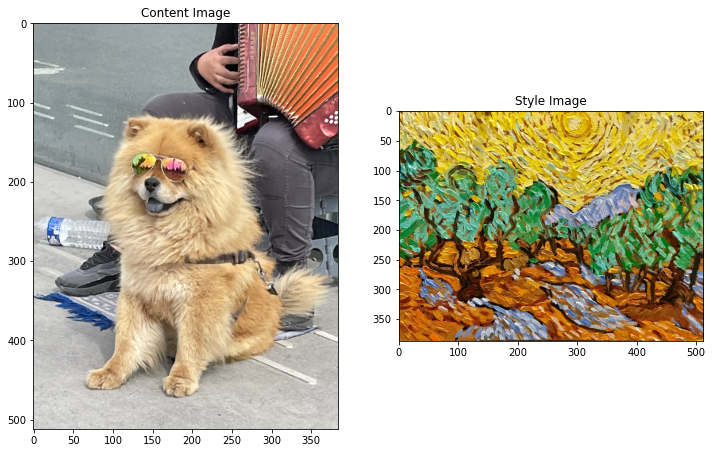

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

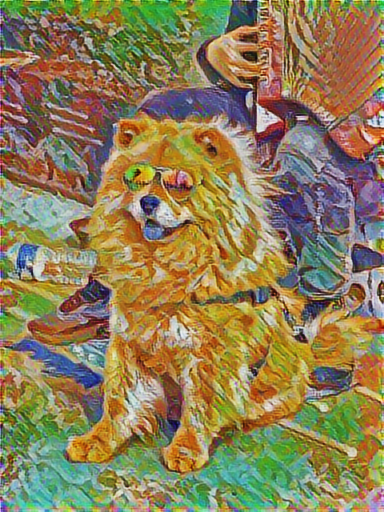

In [8]:
# MODELO PREENTRENADO

import tensorflow_hub as hub

# hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

_____

### Entrenamiento del modelo

Solo ejecutar si se quiere volver a entrenar el modelo.

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Pomeranian', 0.6409817),
 ('chow', 0.34813425),
 ('keeshond', 0.0075981086),
 ('muzzle', 0.0014091042),
 ('Pekinese', 0.00059707183)]

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
    
  # Creates a vgg model that returns a list of intermediate output values.
  # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 387, 512, 64)
  min:  0.0
  max:  812.2899
  mean:  40.92901

block2_conv1
  shape:  (1, 193, 256, 128)
  min:  0.0
  max:  4012.609
  mean:  222.19974

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  9704.384
  mean:  235.82062

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  22162.418
  mean:  811.45416

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  4291.255
  mean:  54.069195



In [16]:
def gram_matrix(input_tensor):
    
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result/(num_locations)

In [17]:
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.05344348
    max:  38900.34
    mean:  449.76538

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  122376.91
    mean:  16213.166

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  400031.84
    mean:  16472.17

   block4_conv1
    shape:  (1, 512, 512)
    min:  3.797609
    max:  2858503.8
    mean:  247790.9

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  148019.4
    mean:  2562.3975

Contents:
   block5_conv2
    shape:  (1, 32, 24, 512)
    min:  0.0
    max:  2110.0344
    mean:  20.912453


In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [20]:
image = tf.Variable(content_image)

In [21]:
image

<tf.Variable 'Variable:0' shape=(1, 512, 384, 3) dtype=float32, numpy=
array([[[[0.5786765 , 0.6178922 , 0.6218138 ],
         [0.5916667 , 0.6308824 , 0.6387255 ],
         [0.58439034, 0.623606  , 0.63144916],
         ...,
         [0.64126843, 0.46078435, 0.25507048],
         [0.69342834, 0.5130362 , 0.3169577 ],
         [0.7933518 , 0.59630823, 0.39039525]],

        [[0.59367347, 0.63288915, 0.6368107 ],
         [0.58700985, 0.62622553, 0.63406867],
         [0.5808824 , 0.62009805, 0.6279412 ],
         ...,
         [0.6522059 , 0.48357844, 0.2757353 ],
         [0.6912071 , 0.5068934 , 0.29681373],
         [0.72809434, 0.49211094, 0.28270528]],

        [[0.59681374, 0.6360294 , 0.639951  ],
         [0.5889706 , 0.6281863 , 0.6360294 ],
         [0.58357847, 0.62279415, 0.6306373 ],
         ...,
         [0.82192105, 0.644853  , 0.430959  ],
         [0.7666974 , 0.5622549 , 0.3387255 ],
         [0.8463236 , 0.57238054, 0.34420955]],

        ...,

        [[0.83889407,

In [22]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [24]:
style_weight=1e-2
content_weight=1e4

In [25]:
def style_content_loss(outputs):
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    
    return loss

In [26]:
@tf.function()

def train_step(image):
    
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

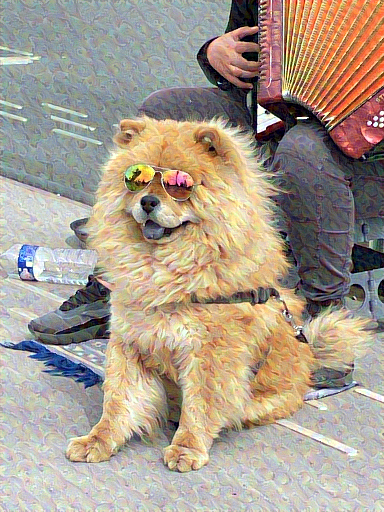

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

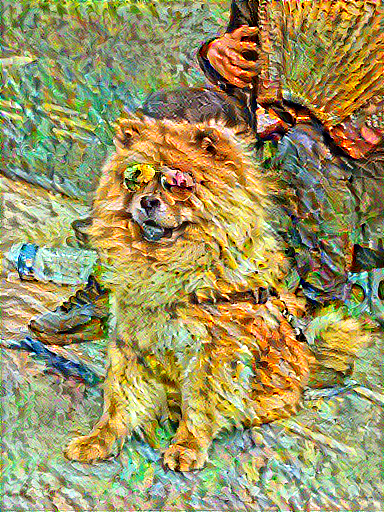

Train step: 500
Total time: 2802.0


In [28]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

_____

In [30]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

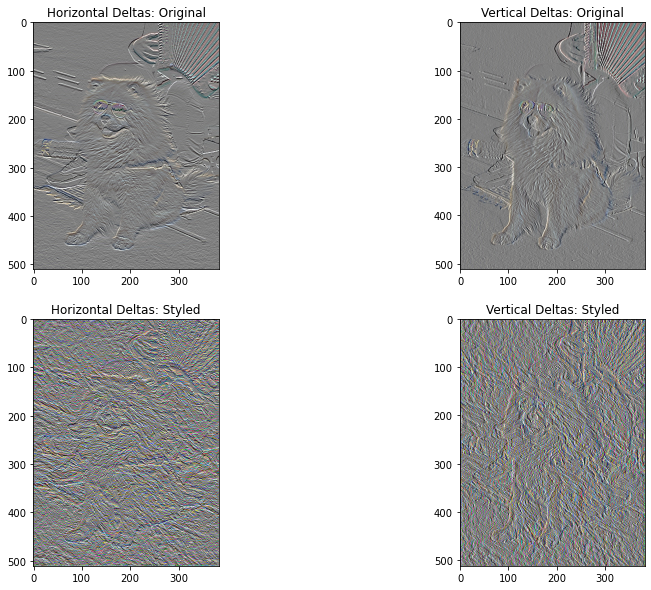

In [31]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

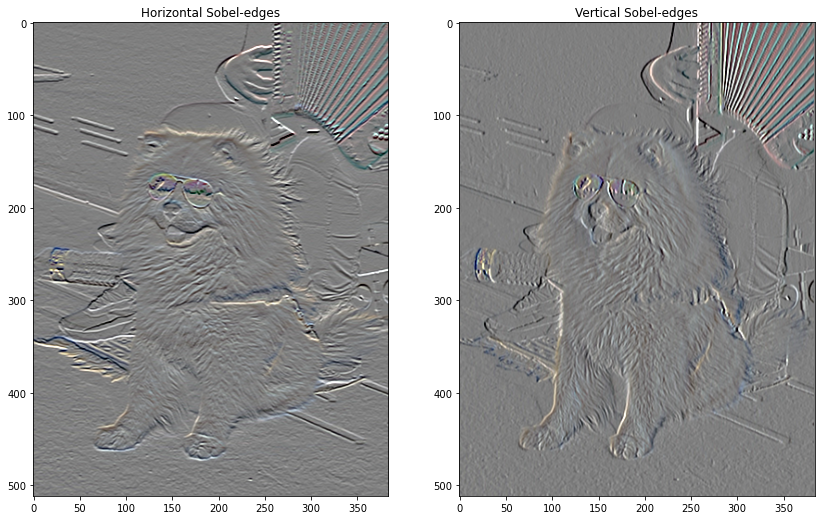

In [32]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [33]:
def total_variation_loss(image):
    
    x_deltas, y_deltas = high_pass_x_y(image)
    
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [34]:
total_variation_loss(image).numpy()

149021.62

In [35]:
tf.image.total_variation(image).numpy()

array([149021.62], dtype=float32)

In [36]:
total_variation_weight=30

In [37]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

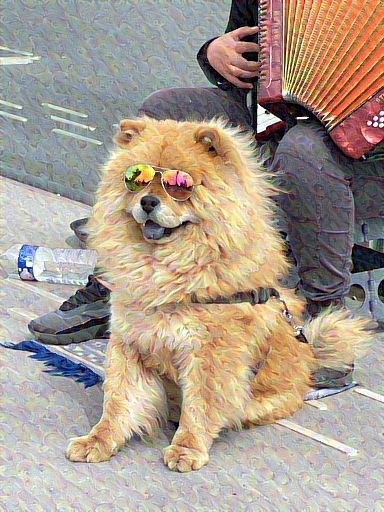

In [39]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

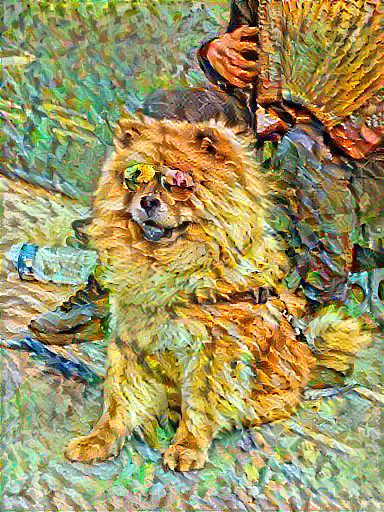

Train step: 500
Total time: 1849.9


In [40]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

_____________